# Baseline Modelling

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from scipy.sparse import issparse
from sklearn.manifold import TSNE

In [2]:
import os
import sys
from pathlib import Path

path = Path(os.path.dirname(os.getcwd()))
path = str(path)
print(path)
sys.path.insert(1, path)

/Users/saideepbunny/Projects/Application_Ranking_System


## Reading the data

In [3]:
df = pd.read_csv(f"{path}/data/synthetic_data/synthetic_data_v1.csv")
df

,job_data,resume_data,label
0,Master Scheduler\nBaltimore Aircoil Company (B...,# *John Miller*\n\n**Professional Summary**\n\...,Complete Mismatch
1,Master Scheduler\nBaltimore Aircoil Company (B...,# James Casey\n\n## Professional Summary\n\nHi...,Underwhelming
2,Master Scheduler\nBaltimore Aircoil Company (B...,# Rachel Vargas\n\n## Professional Summary\n\n...,Good Fit
3,Master Scheduler\nBaltimore Aircoil Company (B...,# Susan Bradley\n\n**Professional Summary**\n\...,Overqualified
4,Master Technician\nCompany / Location Informat...,# Sean Johnson\n\n## Professional Summary\n\nD...,Complete Mismatch
...,...,...,...
5995,Account Executive Digital Sales\nOverview\nSal...,# Todd Walters\n\n**Professional Summary**\n\n...,Overqualified
5996,"Account Executive, Industrial Equipment\nWith ...",**DOUGLAS BLAKE**\n\n**Professional Summary**\...,Complete Mismatch
5997,"Account Executive, Industrial Equipment\nWith ...",# Kyle Villegas\n\n## Professional Summary\n\n...,Underwhelming
5998,"Account Executive, Industrial Equipment\nWith ...",# Charles Preston\n\n**Professional Summary**\...,Good Fit


In [4]:
print("Number of rows in the dataset:", df.shape[0])
print("Number of columns in the dataset:", df.shape[1])

Number of rows in the dataset: 6000
Number of columns in the dataset: 3


In [5]:
df['label'].value_counts()

label
Complete Mismatch    1518
Underwhelming        1499
Good Fit             1498
Overqualified        1485
Name: count, dtype: int64

## Data preprocessing

In [6]:
# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.add("overqualified")
stop_words.add("underqualified")
stop_words.add("mismatch")
stop_words.add("good")
print(stop_words)

{'underqualified', 'their', 'after', 'now', 'about', 'has', 'theirs', 'wouldn', 'why', 'both', 'having', 'these', 'so', 'isn', "it's", 'couldn', 'shouldn', 'them', "wouldn't", "weren't", "you've", "we've", 'hadn', "couldn't", 'aren', 'this', 'that', 'mightn', 'those', 'we', 'same', "shan't", 'only', 'shan', "we're", 'o', 'how', 'is', 'while', 'very', 'in', "she's", 'didn', 'until', 'here', "they're", 'herself', 'had', 's', 'during', 'with', 'hers', 'itself', "wasn't", 'just', "mustn't", "should've", 'am', 'mustn', 'ain', "needn't", 'but', 'y', 'overqualified', 'good', 'a', 'can', 'myself', 'won', "hadn't", 'over', 'our', 'from', "mightn't", "she'd", "i'd", 'will', 'being', 'it', 'have', 'or', 't', 'mismatch', 'when', 'further', "it'll", 'her', "isn't", 'out', 'd', 'i', 'were', 'he', "it'd", 'your', "shouldn't", 'to', 'll', 'of', "i've", "i'm", 'weren', 'do', 'up', 'as', 'above', 'most', 'between', "didn't", 'been', "he'd", "aren't", 'needn', "they'd", 'on', 'an', 'through', 'because', 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saideepbunny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove unwanted symbols except %, $, /, and .
    text = re.sub(r"[^a-z0-9\s%$/.-]", "", text)

    # Preserve hyphens only when followed by a number (e.g., 2005-2010, 2010-present)
    text = re.sub(r"-(?!\d)", "", text)  # Remove hyphens not followed by a digit

    # Preserve GPA-like formats (e.g., 3.8/4.0)
    text = re.sub(r"(?<!\d)/|/(?!\d)", " ", text)  # Remove '/' unless between numbers

    # Remove periods (".") if they are immediately after a word but not numbers (e.g., "good." → "good", but keep 3.8)
    text = re.sub(r"\b(\w+)\.(?!\d)", r"\1", text)

    # Remove newline characters
    text = text.replace("\n", " ").replace("\r", " ")

    # Remove any show less and show more texts
    text = text.replace("show less", "").replace("show more", "")
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    text = " ".join(word for word in text.split() if word not in stop_words)

    return text

In [8]:
df['job_data_preprocessed'] = df['job_data'].apply(preprocess_text)
df['resume_data_preprocessed'] = df['resume_data'].apply(preprocess_text)

In [9]:
print(df.iloc[100]['job_data'])
print("\n******************************************************\n")
print(df.iloc[100]['job_data_preprocessed'])

Mortgage Advisor
At Pinnacle, our goal is to create an atmosphere where people become fully engaged, enjoy what they're doing and be successful. We work to ensure that every associate embraces what makes Pinnacle different and unique. For us, it starts with hiring the right people.
We hire like-minded individuals who share our values of Integrity, Fairness, Learning, Results, Partnership, Balance, and Discipline.
We hire experienced professionals who understand the industry and provide effective advice.
We hire candidates who demonstrate a passion for client service. People who understand that distinctive service is more than smiling and being friendly – it’s about creating a client experience that is unmatched.
But attracting the right people is only half the battle. We have to ensure that every associate understands their actions affects the outcomes of the firm. Our Position Descriptions are not designed to list every aspect of a position but to serve as a general overview.
Summary 

In [10]:
print(df.iloc[100]['resume_data'])
print("\n******************************************************\n")
print(df.iloc[100]['resume_data_preprocessed'])

# *Heather Neal*

**Professional Summary**

Dedicated and experienced *Veterinarian* with a strong background in animal care and welfare. Proven ability to manage high-volume caseloads, provide compassionate care, and maintain positive relationships with clients. Seeking to leverage expertise in a new and challenging role.

**Skills**

- Animal handling and restraint
- Surgical procedures
- Diagnostic testing and interpretation
- Client communication and education
- Electronic medical records management
- Team leadership and development
- Public speaking and presentations
- Microsoft Office (Word, Excel, PowerPoint)
- Veterinary software (AVImark, ImproMed)
- Animal nutrition and behavior
- Emergency and critical care
- Exotic animal medicine
- Preventative care and wellness

**Education**

*University of California, Davis*

- Doctor of Veterinary Medicine, 2005
- GPA: 3.8/4.0

**Work Experience**

*ABC Animal Hospital*

- *Veterinarian*, Full-time, 2010-2021
  - Provided comprehensive

## Modelling: TF-IDF

### Utility Functions

In [11]:
def cross_validation_scores(model, X, y, n_splits=5):
    # Define k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    
    # Print results
    print(f"Cross-validation scores: {scores}")
    print(f"Mean accuracy: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")
    
    
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """
    Displays a confusion matrix using seaborn heatmap.

    Parameters:
    y_true : list or array
        True labels.
    y_pred : list or array
        Predicted labels.
    labels : list, optional
        Class labels for the confusion matrix.
    title : str, optional
        Title of the plot.
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

### Defining X and y

In [12]:
X = df[['job_data_preprocessed', 'resume_data_preprocessed']].copy()
y = df['label']

### Train test split

In [13]:
# Assuming X contains features and y contains labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Train data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)

Train data shape:  (4800, 2)
Test data shape:  (1200, 2)


### Performing TF-IDF

In [14]:
# Initialize separate TF-IDF vectorizers
tfidf1 = TfidfVectorizer(max_df=0.7, min_df=0.2, max_features=5000)
tfidf2 = TfidfVectorizer(max_df=0.7, min_df=0.2, max_features=5000)

# Transform text columns separately
X_train_tfidf1 = tfidf1.fit_transform(X_train['job_data_preprocessed'])
X_train_tfidf2 = tfidf2.fit_transform(X_train['resume_data_preprocessed'])

# Combine TF-IDF features (horizontally stack them)
X_train_transformed = hstack([X_train_tfidf1, X_train_tfidf2])


# Transform text columns separately
X_test_tfidf1 = tfidf1.transform(X_test['job_data_preprocessed'])
X_test_tfidf2 = tfidf2.transform(X_test['resume_data_preprocessed'])

# Combine TF-IDF features (horizontally stack them)
X_test_transformed = hstack([X_test_tfidf1, X_test_tfidf2])

### Decision Tree Classifier

In [15]:
model = DecisionTreeClassifier(random_state=42)  # Example model
cross_validation_scores(model, X_train_transformed, y_train, n_splits=5)


Cross-validation scores: [0.83333333 0.828125   0.834375   0.840625   0.80520833]
Mean accuracy: 0.8283
Standard deviation: 0.0122


In [16]:
# Train model on full training set
model.fit(X_train_transformed, y_train)

# Evaluate on test set
y_pred = model.predict(X_test_transformed)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Complete Mismatch       0.86      0.83      0.85       304
         Good Fit       0.75      0.81      0.78       299
    Overqualified       0.82      0.79      0.80       297
    Underwhelming       0.89      0.87      0.88       300

         accuracy                           0.83      1200
        macro avg       0.83      0.83      0.83      1200
     weighted avg       0.83      0.83      0.83      1200


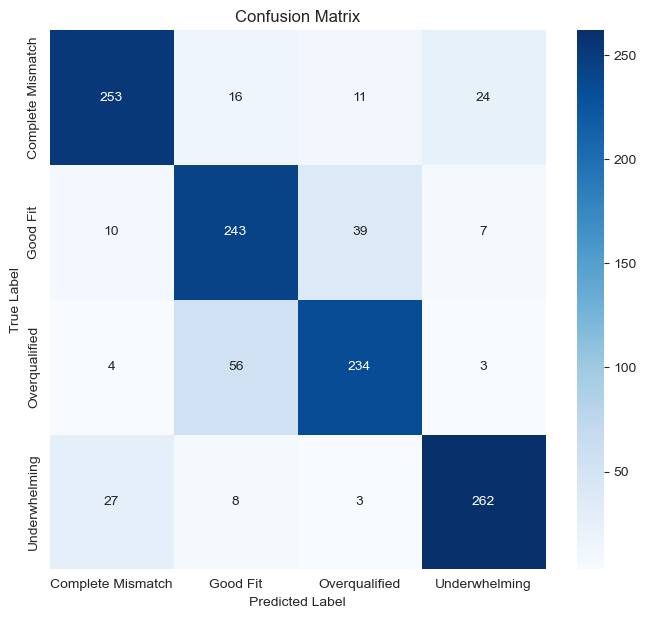

In [17]:
plot_confusion_matrix(y_test, y_pred, ["Complete Mismatch", "Good Fit", "Overqualified", "Underwhelming"])

### RandomForestClassifier

In [18]:
model = RandomForestClassifier(random_state=42)  # Example model
cross_validation_scores(model, X_train_transformed, y_train, n_splits=5)


Cross-validation scores: [0.95208333 0.953125   0.95208333 0.95104167 0.94270833]
Mean accuracy: 0.9502
Standard deviation: 0.0038


In [19]:
# Train model on full training set
model.fit(X_train_transformed, y_train)

# Evaluate on test set
y_pred = model.predict(X_test_transformed)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Complete Mismatch       0.96      0.98      0.97       304
         Good Fit       0.93      0.95      0.94       299
    Overqualified       0.95      0.91      0.93       297
    Underwhelming       0.98      0.98      0.98       300

         accuracy                           0.96      1200
        macro avg       0.96      0.96      0.96      1200
     weighted avg       0.96      0.96      0.96      1200


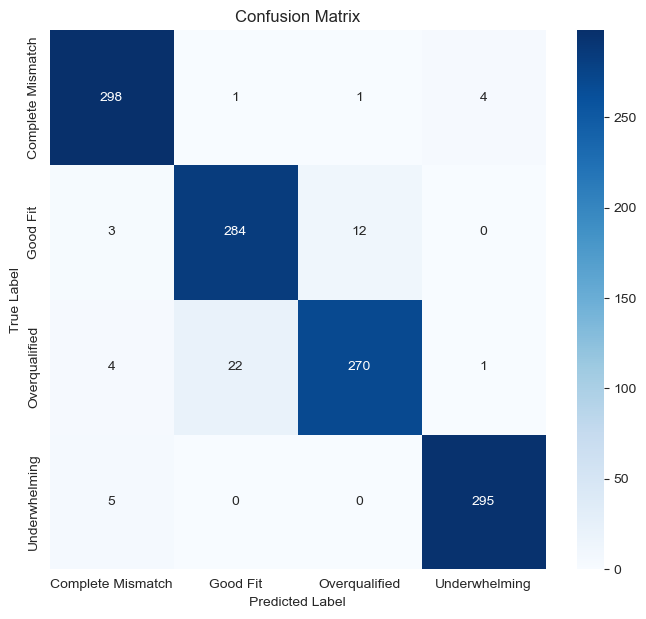

In [20]:
plot_confusion_matrix(y_test, y_pred, ["Complete Mismatch", "Good Fit", "Overqualified", "Underwhelming"])

#### Checking for most important features

Since we are using TF-IDF, words would be our features. We are trying to see if there are any features that are directly correlated to target. This gives us information if there is any Data Leakage

In [21]:
# Get Feature Importance from XGBoost
feature_importance = model.feature_importances_

# Get Feature Names
job_features = np.array(tfidf1.get_feature_names_out())  # Job description words
resume_features = np.array(tfidf2.get_feature_names_out())  # Resume words

# Split importance back into Job Description & Resume parts
job_feature_importance = feature_importance[:len(job_features)]
resume_feature_importance = feature_importance[len(job_features):]

# Create Sorted DataFrames
job_df = pd.DataFrame({'Word': job_features, 'Importance': job_feature_importance}).sort_values(by="Importance", ascending=False)
resume_df = pd.DataFrame({'Word': resume_features, 'Importance': resume_feature_importance}).sort_values(by="Importance", ascending=False)

In [22]:
job_df.head(30)

,Word,Importance
36,care,0.001898
297,systems,0.001450
76,design,0.001403
96,engineering,0.001263
125,health,0.001198
282,software,0.001182
283,solutions,0.001168
65,data,0.001114
95,engineer,0.001065
249,quality,0.001058


In [23]:
resume_df.head(30)

,Word,Importance
142,seeking,0.041451
4,2010,0.029003
12,25,0.028992
151,strategic,0.025990
3,2005,0.023880
29,background,0.022191
71,highly,0.021215
130,reducing,0.021083
13,30,0.018756
2,20,0.017084


The high performance might be due to clear decision boundaries as each of the resume with different fit categories is designed to be widely different from one category to another.

### Analyzing prediction probabilities

In [24]:
# 0-Complete Mismatch
# 1-Good fit
# 2-Overqualified
# 3-Underwhelming

result_df = pd.DataFrame()
result_df['label'] = y_test
result_df['predicted_label'] = y_pred

prob_cols = ['Complete Mismatch_prob', 'Good Fit_prob', 'Overqualified_prob', 'Underwhelming_prob']
result_df[prob_cols] = model.predict_proba(X_test_transformed)
result_df

,label,predicted_label,Complete Mismatch_prob,Good Fit_prob,Overqualified_prob,Underwhelming_prob
4411,Overqualified,Overqualified,0.00,0.05,0.95,0.00
1024,Complete Mismatch,Complete Mismatch,0.67,0.18,0.06,0.09
2917,Underwhelming,Underwhelming,0.10,0.00,0.00,0.90
4613,Underwhelming,Underwhelming,0.25,0.04,0.06,0.65
586,Good Fit,Good Fit,0.05,0.73,0.13,0.09
...,...,...,...,...,...,...
4177,Underwhelming,Underwhelming,0.03,0.02,0.03,0.92
4774,Good Fit,Good Fit,0.04,0.66,0.29,0.01
3289,Underwhelming,Complete Mismatch,0.46,0.14,0.12,0.28
4406,Good Fit,Good Fit,0.03,0.71,0.22,0.04


In [25]:
def plot_histogram(df, col, log_scale=True):
    sns.set_style("darkgrid")
    sns.histplot(data = df, x=col, bins=20, kde=True)
    plt.title(f"Distribution of {col}")
    if(log_scale):
        plt.yscale("log")
    plt.show()

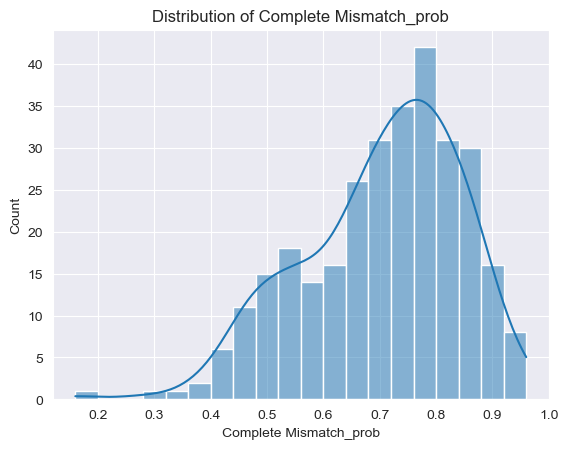

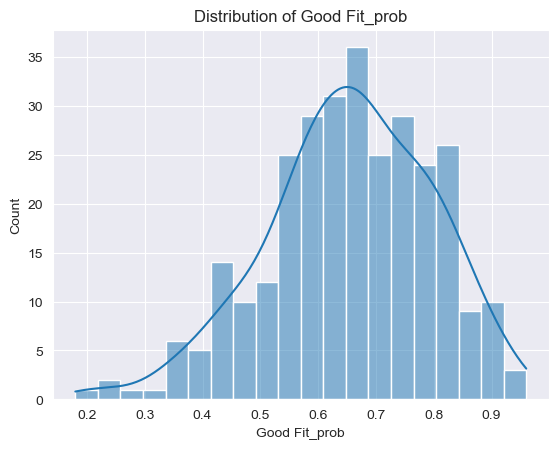

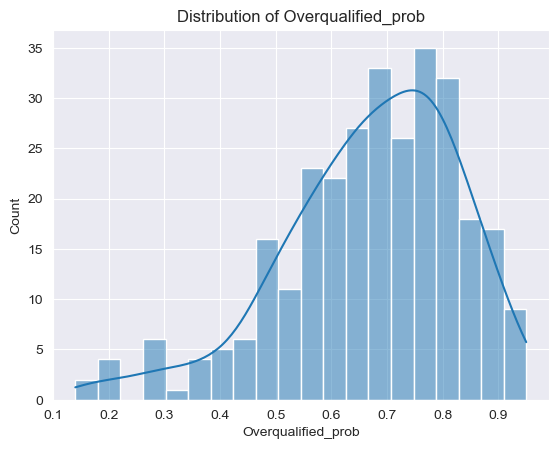

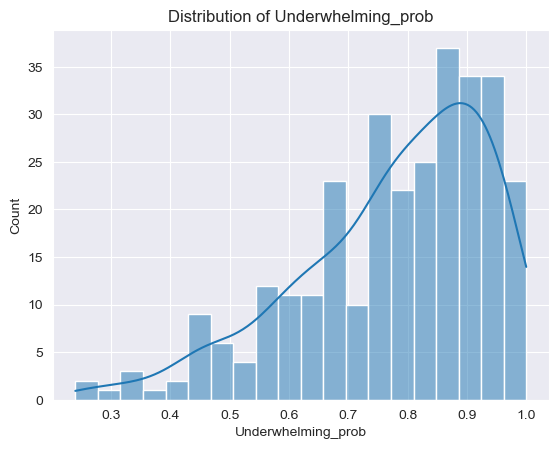

In [26]:
for i in prob_cols:
    category = i.split("_")[0]
    temp = result_df[result_df['label'] == category].copy()
    plot_histogram(temp, i, log_scale=False)

## Ablation studies

Deliberately removing input features to test model performance.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def select_percentage_of_columns(X, percentage, random_state=None):
    """
    Randomly selects a given percentage of columns from feature matrix X.
    
    Parameters:
    -----------
    X : numpy array or pandas DataFrame
        The feature matrix
    percentage : float
        Percentage of columns to select (between 0 and 100)
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    X_subset : same type as X
        Feature matrix with selected columns
    selected_columns : list or array
        The names or indices of selected columns
    """
    np.random.seed(random_state)
    
    if percentage <= 0 or percentage > 100:
        raise ValueError("Percentage must be between 0 and 100")
    
    # Calculate number of columns to select
    n_cols = X.shape[1]
    n_select = max(1, int(n_cols * percentage / 100))
    
    if isinstance(X, pd.DataFrame):
        # For pandas DataFrames
        all_cols = list(X.columns)
        selected_columns = np.random.choice(all_cols, size=n_select, replace=False)
        return X[selected_columns], selected_columns
    else:
        # For numpy arrays
        selected_indices = np.random.choice(n_cols, size=n_select, replace=False)
        return X[:, selected_indices], selected_indices

def evaluate_feature_percentages(X_train, y_train, X_test, y_test, percentages, n_runs=3, test_size=0.2, random_state=42):
    """
    Evaluates model performance with varying percentages of features.
    
    Parameters:
    -----------
    X : numpy array or pandas DataFrame
        Feature matrix
    y : numpy array or pandas Series
        Target labels
    percentages : list
        List of percentages of features to use
    n_runs : int
        Number of runs for each percentage (with different random features)
    test_size : float
        Proportion of data to use for testing
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    results_df : pandas DataFrame
        Results with mean and std accuracy for each percentage
    """
    
    results = []
    
    for percentage in percentages:
        run_accuracies = []
        
        for run in range(n_runs):
            # Select features
            X_train_subset, selected_cols = select_percentage_of_columns(
                X_train, percentage, random_state=random_state + run
            )
            
            # Use same columns for test set
            if isinstance(X_test, pd.DataFrame):
                X_test_subset = X_test[selected_cols]
            else:
                X_test_subset = X_test[:, selected_cols]
            
            # Train and evaluate model
            model = RandomForestClassifier(random_state=random_state)
            model.fit(X_train_subset, y_train)
            y_pred = model.predict(X_test_subset)
            accuracy = accuracy_score(y_test, y_pred)
            run_accuracies.append(accuracy)
        
        # Store results
        mean_acc = np.mean(run_accuracies)
        std_acc = np.std(run_accuracies)
        results.append({
            'percentage': percentage,
            'mean_accuracy': mean_acc,
            'std_accuracy': std_acc,
            'min_accuracy': np.min(run_accuracies),
            'max_accuracy': np.max(run_accuracies)
        })
    
    return pd.DataFrame(results)

def plot_feature_ablation(results_df):
    """
    Creates a line plot of feature ablation results with error bands.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot mean accuracy line
    plt.plot(
        results_df['percentage'], 
        results_df['mean_accuracy'] * 100, 
        'o-', 
        color='blue', 
        linewidth=2,
        label='Mean Accuracy'
    )
    
    # Plot error bands
    plt.fill_between(
        results_df['percentage'],
        (results_df['mean_accuracy'] - results_df['std_accuracy']) * 100,
        (results_df['mean_accuracy'] + results_df['std_accuracy']) * 100,
        color='blue', 
        alpha=0.2,
        label='± 1 std dev'
    )
    
    # Add min/max range
    plt.fill_between(
        results_df['percentage'],
        results_df['min_accuracy'] * 100,
        results_df['max_accuracy'] * 100,
        color='gray', 
        alpha=0.1,
        label='Min-Max Range'
    )
    
    # Customize plot
    plt.xlabel('Percentage of Features Used (%)', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Model Performance vs. Feature Percentage', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right')
    plt.tight_layout()

    # Show plot
    plt.show()



In [28]:
# Define percentages to test (10%, 20%, ..., 100%)
percentages = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    
# Run evaluation
results = evaluate_feature_percentages(X_train_transformed, y_train, X_test_transformed, y_test, percentages, n_runs=5)
results

,percentage,mean_accuracy,std_accuracy,min_accuracy,max_accuracy
0,1,0.309833,0.077975,0.195000,0.379167
1,5,0.637667,0.070036,0.520833,0.726667
2,10,0.748167,0.030402,0.692500,0.777500
3,20,0.854167,0.020255,0.833333,0.887500
4,30,0.885000,0.020159,0.868333,0.924167
5,40,0.915667,0.015460,0.895833,0.935833
6,50,0.926500,0.014543,0.909167,0.946667
7,60,0.937000,0.009554,0.921667,0.950833
8,70,0.941833,0.006980,0.930833,0.949167
9,80,0.948000,0.004137,0.942500,0.952500


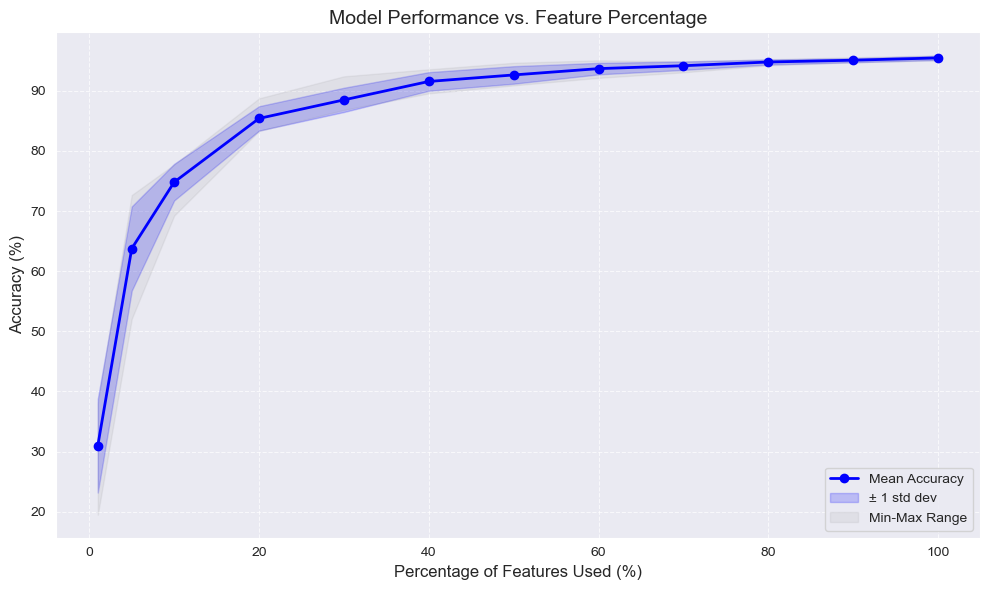

In [29]:
# Plot results
plot_feature_ablation(results)

- There's a significant inflection point around 20-30% of features (100-150 features), where you reach approximately 80-85% accuracy. After this point, adding more features provides increasingly marginal benefits.
- Performance doesn't collapse even with very few features, suggesting information is distributed across many features rather than concentrated in just a few critical ones.
- The narrow error bands at higher feature percentages indicate consistent performance, while the wider bands at lower percentages show that the specific features selected become more critical when you have fewer of them.
- The flattening curve after 50% suggests considerable redundancy in your feature set - many features contain similar or correlated information.

## Final thoughts

TF-IDF is not a reliable method to predict classes. This is because, if the features that are present in the training set are absent in the test data or real world the model would fail in generalization. 

Using more robust text embeddings like using Sentence transformers gives more robust results.